# Regression Practice 

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if (torch.cuda.is_available()==True) else "cpu")

In [2]:
data = pd.read_csv("..\\Datasets\\SimpleLinearRegression.csv")
X = torch.tensor(data['YearsExperience'].values, dtype=torch.float32).unsqueeze(dim=1).to(device)
y= torch.tensor(data['Salary'].values, dtype=torch.float32).unsqueeze(dim=1).to(device)
scaler = StandardScaler()
y= torch.tensor(scaler.fit_transform(y.cpu()), dtype=torch.float32).to(device)
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2)

### Plot fn


In [3]:
def plot_pred(y_pred=None,X = X_test.cpu(),y=y_test.cpu()):
    plt.figure(figsize=(10,6))
    plt.scatter(X,y, label = "Actual Data")
    if y_pred is not None:
        plt.plot(X,y_pred.cpu(), label = "Predicted Data")
    plt.legend()
    plt.show()

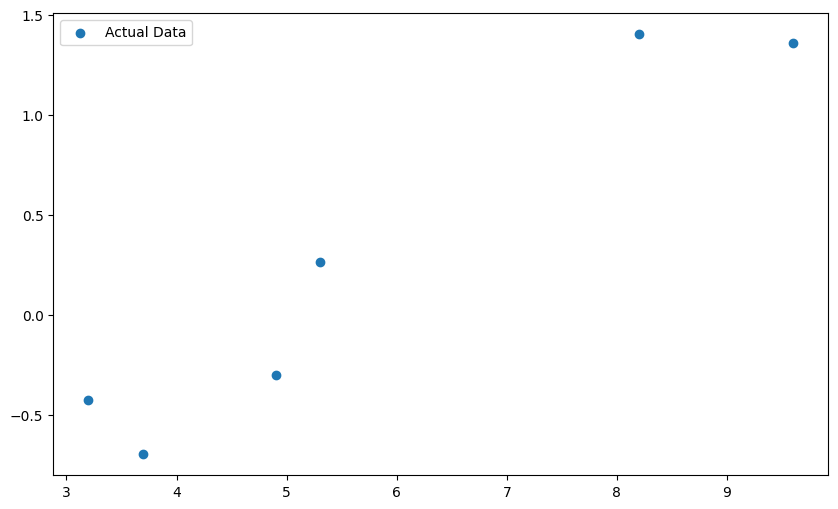

In [4]:
plot_pred()

## Model Building

In [5]:
class regression_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float32))
        
        self.weight = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float32))
    
    def forward(self, X):
        return self.bias + self.weight*X


model = regression_model().to(device)
model.state_dict()

OrderedDict([('bias', tensor([0.3367], device='cuda:0')),
             ('weight', tensor([0.1288], device='cuda:0'))])

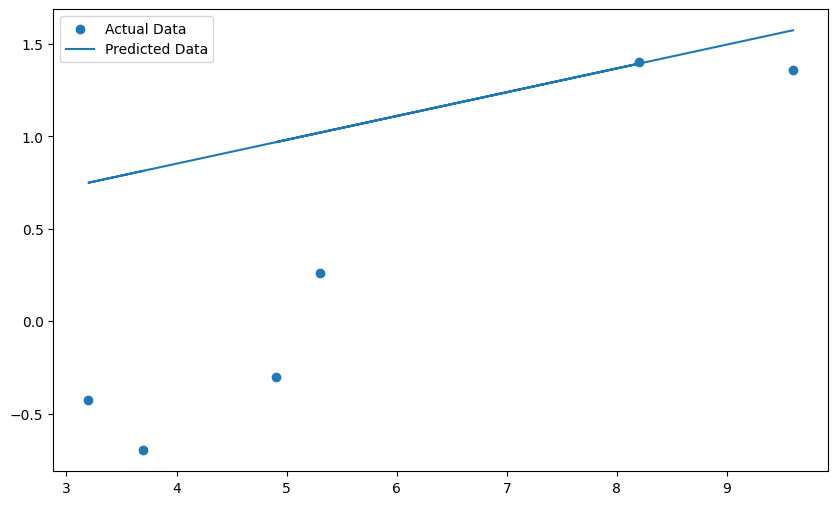

In [6]:
with torch.inference_mode():
    y_pred = model(X_test)
plot_pred(y_pred)

## Optimizer and Loss Function

In [7]:
optim_fn = torch.optim.SGD(params = model.parameters(),
                           lr=0.001)
loss_fn = nn.L1Loss()

## Training /Testing Loop

In [8]:
device

device(type='cuda')

OrderedDict({'bias': tensor([-1.4135], device='cuda:0'), 'weight': tensor([0.2938], device='cuda:0')})


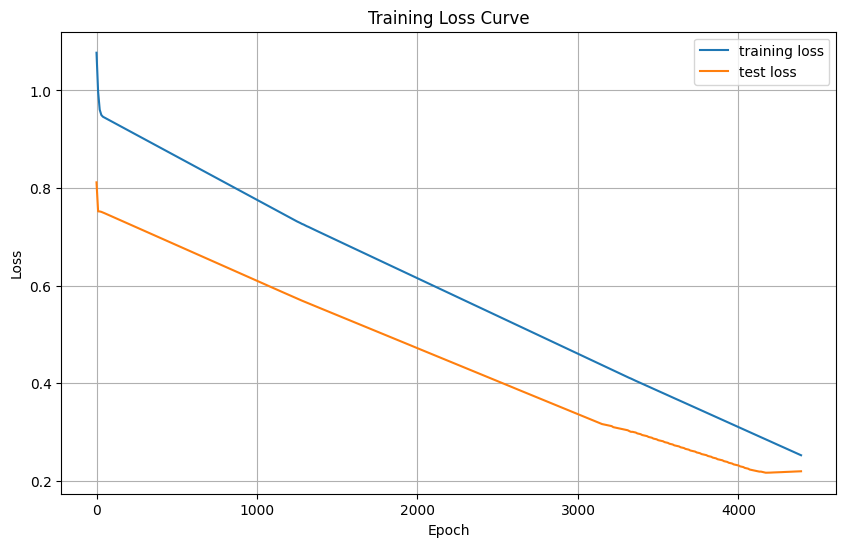

In [9]:
# Epoc is a loop through the data
epochs = 4400
epoch_count = []
lossval = []
test_loss_vals = []
#0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model.train() # Train mode in PyTorch sets all parameters that require grads to have gradients
    
    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Loss
    loss = loss_fn(y_pred,y_train)

    # 3. Set grads to zero
    optim_fn.zero_grad()

    #4. Backward Pass
    loss.backward()

    #5. Update value
    optim_fn.step()
    
    # Testing
    if epoch % 10==0:
        model.eval() 
        with torch.inference_mode():
            # 1. forward pass
            test_pred = model(X_test)

            #2. Calculate the loss
            test_loss = loss_fn(test_pred,y_test)

            lossval.append(loss.item())
            epoch_count.append(epoch)
            test_loss_vals.append(test_loss.item())

            
print(model.state_dict())
plt.figure(figsize=(10, 6))
plt.plot(epoch_count,lossval, label = "training loss")
plt.plot(epoch_count,test_loss_vals, label = "test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()


In [10]:
X_test

tensor([[9.6000],
        [4.9000],
        [8.2000],
        [5.3000],
        [3.2000],
        [3.7000]], device='cuda:0')

In [11]:
model.state_dict()

OrderedDict([('bias', tensor([-1.4135], device='cuda:0')),
             ('weight', tensor([0.2938], device='cuda:0'))])

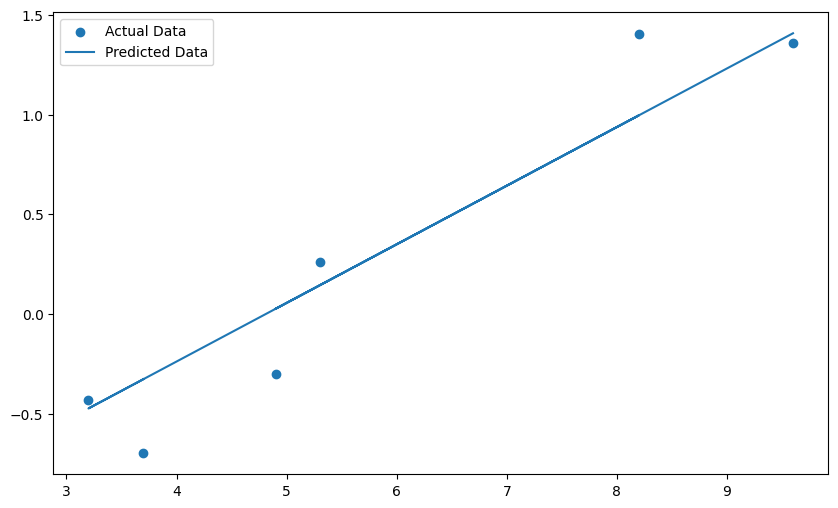

0.8471158288725313


In [12]:
with torch.inference_mode():
    y_pred = model(X_test)
plot_pred(y_pred)
print(r2_score(y_pred.cpu(),y_test.cpu()))

## Saving and Loading


In [13]:
# Saving the model
path = "../models/Prac_PyTorch_Workflow"
torch.save({"State_dict":model.state_dict()
            ,"Scaler":scaler},path)

In [14]:
# Loading the model
load = torch.load(path,weights_only=False)
scaler = load["Scaler"]
model = regression_model().to(device)
model.load_state_dict(load["State_dict"])

<All keys matched successfully>

In [15]:
with torch.inference_mode():
    y_p = model(X_test)
print(r2_score(scaler.inverse_transform(y_p.cpu()),scaler.inverse_transform(y_test.cpu())))

0.8471158288725313
